In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

from typing import Tuple, Dict
from torch.utils.data import Dataset, DataLoader

In [6]:
def build_20d_return_dataset(
    stock_price: pd.DataFrame | pd.Series,
    market_df: pd.DataFrame,
    sector_df: pd.DataFrame,
    macro_df: pd.DataFrame,
    input_len: int = 60,
    horizon: int = 20,
    train_ratio: float = 0.7,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, Dict[str, np.ndarray]]:
    """
    단일 종목 20일 수익률을 예측하기 위한 LTSF용 (X, y) 데이터셋을 만듭니다.

    Parameters
    ----------
    stock_price : pd.Series or 1-col DataFrame
        타깃 종목 가격
    market_df : pd.DataFrame
        마켓 인덱스들 (예: SPX, NASDAQ, RUSSELL 등)
    sector_df : pd.DataFrame
        11 섹터 지수
    macro_df : pd.DataFrame
        금리(3M, 2Y, 10Y), 실업률, 인플레, 유가, 환율 등
    input_len : int
        입력 윈도우 길이 (예: 60일)
    horizon : int
        예측 horizon (20일 수익률 → 20)
    train_ratio : float
        시간 기준 train 비율 (예: 0.7 → 앞 70% 구간을 train으로 사용)

    Returns
    -------
    X_train, y_train, X_val, y_val : np.ndarray
        X_* : (N, input_len, D_features)
        y_* : (N,)  # 스칼라 20일 수익률
    scaler : dict
        {'mean': (1, D), 'std': (1, D)}  # feature 정규화용
    """

    # --------- stock_price를 Series로統一 ---------
    if isinstance(stock_price, pd.DataFrame):
        if stock_price.shape[1] != 1:
            raise ValueError("stock_price DataFrame은 한 개의 컬럼만 가져야 합니다.")
        stock_series = stock_price.iloc[:, 0].copy()
    else:
        stock_series = stock_price.copy()

    stock_series.name = "target_stock"

    # --------- 날짜 기준으로 모든 피처 병합 (inner join) ---------
    # macro는 월간/불규칙일 수도 있으므로, 먼저 ffill로 일단위로 늘려주는게 안전
    macro_df = macro_df.sort_index().copy()
    macro_df = macro_df.asfreq("B", method="ffill")  # 영업일 기준으로 forward-fill
    market_df = market_df.sort_index().asfreq("B", method="ffill")
    sector_df = sector_df.sort_index().asfreq("B", method="ffill")
    stock_series = stock_series.sort_index().asfreq("B")  # 가격은 비는 날 있을 수 있음

    full = pd.concat(
        [stock_series.to_frame(), market_df, sector_df, macro_df],
        axis=1,
        join="inner",
    ).sort_index()

    # 타깃 종목 가격
    price = full["target_stock"]

    # --------- 20일 forward 수익률 계산 ---------
    # r_t(20일) = P_{t+20}/P_t - 1
    future_price = price.shift(-horizon)
    y_series = (future_price / price - 1.0).astype(np.float32)

    # feature는 full 전체를 사용 (타깃 종목 과거 가격 + 마켓/섹터/매크로)
    features = full.astype(np.float32)
    values = features.values  # (T, D_features)
    T, D = values.shape

    # --------- 결측치 일단 남겨두고 train/val split용 index 계산 ---------
    split_T = int(T * train_ratio)

    # --------- 정규화 (train 구간 기준, NaN 무시) ---------
    train_vals = values[:split_T]
    mean = np.nanmean(train_vals, axis=0, keepdims=True)  # (1, D)
    std = np.nanstd(train_vals, axis=0, keepdims=True) + 1e-8

    data_norm = (values - mean) / std
    data_norm = np.nan_to_num(data_norm, nan=0.0).astype(np.float32)  # NaN은 0으로

    y_all = y_series.values  # (T,)

    # --------- 시퀀스 생성 (input_len 길이 윈도우 → 20일 수익률) ---------
    X_train_list, y_train_list = [], []
    X_val_list, y_val_list = [], []

    # t : 윈도우의 마지막 index (y_t를 예측)
    # y_t는 P_{t+20}/P_t -1 이므로, t는 [0, T-horizon-1] 범위에서만 유효
    start_t = input_len - 1
    end_t = T - horizon - 1  # inclusive

    for t in range(start_t, end_t + 1):
        y_t = y_all[t]
        if np.isnan(y_t):
            continue  # 타깃이 NaN이면 sample 버림

        x_window = data_norm[t - input_len + 1 : t + 1, :]  # (input_len, D)

        if t < split_T:
            X_train_list.append(x_window)
            y_train_list.append(y_t)
        else:
            X_val_list.append(x_window)
            y_val_list.append(y_t)

    X_train = np.stack(X_train_list, axis=0)  # (N_train, L, D)
    y_train = np.array(y_train_list, dtype=np.float32)     # (N_train,)
    X_val = np.stack(X_val_list, axis=0)      # (N_val, L, D)
    y_val = np.array(y_val_list, dtype=np.float32)         # (N_val,)

    scaler = {"mean": mean.astype(np.float32), "std": std.astype(np.float32),
              "feature_names": features.columns.to_list()}

    return X_train, y_train, X_val, y_val, scaler

In [7]:
class ReturnDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray):
        """
        X: (N, input_len, D_features)
        y: (N,)  # 20일 수익률
        """
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class LTSFReturnModel(nn.Module):
    """
    Long-Term Time Series Forecasting 스타일로
    입력 (B, L, D_features) → 스칼라 20일 수익률 (B, 1) 예측.

    아이디어:
    - 시간축 L에 대해 Linear(L -> 1)를 적용해 각 feature별 "요약값"을 만들고
    - feature 축에 대해 한 번 더 Linear로 스칼라를 만든다.
    """
    def __init__(self, input_len: int, num_features: int, hidden_dim: int = 64):
        super().__init__()
        self.input_len = input_len
        self.num_features = num_features

        # 시간 방향 요약: (B, D, L) → (B, D, 1)
        self.time_linear = nn.Linear(input_len, 1)

        # feature 방향 요약: (B, D) → (B, hidden_dim) → (B, 1)
        self.feat_mlp = nn.Sequential(
            nn.Linear(num_features, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B, L, D)
        # → (B, D, L)
        x = x.permute(0, 2, 1)
        # 시간 방향 Linear: (B, D, L) → (B, D, 1)
        t_encoded = self.time_linear(x)   # (B, D, 1)
        t_encoded = t_encoded.squeeze(-1) # (B, D)

        # feature 방향 MLP: (B, D) → (B, 1)
        out = self.feat_mlp(t_encoded)    # (B, 1)
        return out.squeeze(-1)            # (B,)  스칼라 20일 수익률

In [8]:
def train_20d_return_model(
    stock_price: pd.DataFrame | pd.Series,
    market_df: pd.DataFrame,
    sector_df: pd.DataFrame,
    macro_df: pd.DataFrame,
    input_len: int = 60,
    horizon: int = 20,
    train_ratio: float = 0.7,
    batch_size: int = 64,
    num_epochs: int = 50,
    lr: float = 1e-3,
    device: str | None = None,
) -> Tuple[LTSFReturnModel, Dict[str, np.ndarray]]:
    """
    마켓/섹터/매크로+단일종목 가격을 인풋으로 사용해
    20일 수익률을 예측하는 LTSFReturnModel을 학습합니다.
    """

    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    X_train, y_train, X_val, y_val, scaler = build_20d_return_dataset(
        stock_price=stock_price,
        market_df=market_df,
        sector_df=sector_df,
        macro_df=macro_df,
        input_len=input_len,
        horizon=horizon,
        train_ratio=train_ratio,
    )

    train_dataset = ReturnDataset(X_train, y_train)
    val_dataset = ReturnDataset(X_val, y_val)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    num_features = X_train.shape[2]
    model = LTSFReturnModel(input_len=input_len, num_features=num_features, hidden_dim=64)
    model.to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_val_loss = np.inf
    best_state = None

    for epoch in range(1, num_epochs + 1):
        # ----- Train -----
        model.train()
        train_loss_sum = 0.0
        train_n = 0

        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(X_batch)          # (B,)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

            train_loss_sum += loss.item() * X_batch.size(0)
            train_n += X_batch.size(0)

        train_loss = train_loss_sum / max(train_n, 1)

        # ----- Validation -----
        model.eval()
        val_loss_sum = 0.0
        val_n = 0

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)

                val_loss_sum += loss.item() * X_batch.size(0)
                val_n += X_batch.size(0)

        val_loss = val_loss_sum / max(val_n, 1)

        print(f"[Epoch {epoch:03d}] Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = model.state_dict()

    if best_state is not None:
        model.load_state_dict(best_state)

    return model, scaler

In [9]:
def predict_20d_return(
    model: LTSFReturnModel,
    scaler: Dict[str, np.ndarray],
    recent_stock: pd.DataFrame | pd.Series,
    recent_market: pd.DataFrame,
    recent_sector: pd.DataFrame,
    recent_macro: pd.DataFrame,
    input_len: int = 60,
) -> float:
    """
    학습된 모델과 최근 input_len일 데이터를 이용해
    향후 20일 수익률을 예측합니다.

    Returns
    -------
    pred_return : float
        예측된 20일 수익률
    """

    # recent_* 들을 동일한 날짜 구간으로 맞추고, build_20d_return_dataset과 동일한 순서로 병합
    if isinstance(recent_stock, pd.DataFrame):
        recent_stock_series = recent_stock.iloc[:, 0]
    else:
        recent_stock_series = recent_stock

    recent_stock_series.name = "target_stock"

    # 인덱스 정렬 및 영업일 빈도 맞추기
    recent_macro = recent_macro.sort_index().asfreq("B", method="ffill")
    recent_market = recent_market.sort_index().asfreq("B", method="ffill")
    recent_sector = recent_sector.sort_index().asfreq("B", method="ffill")
    recent_stock_series = recent_stock_series.sort_index().asfreq("B")

    full_recent = pd.concat(
        [recent_stock_series.to_frame(), recent_market, recent_sector, recent_macro],
        axis=1,
        join="inner",
    ).sort_index()

    if len(full_recent) < input_len:
        raise ValueError("recent 데이터 길이가 input_len보다 짧습니다.")

    full_recent = full_recent.iloc[-input_len:]  # 마지막 input_len일만 사용

    values = full_recent.values.astype(np.float32)  # (L, D)
    mean = scaler["mean"]
    std = scaler["std"]

    data_norm = (values - mean) / std
    data_norm = np.nan_to_num(data_norm, nan=0.0).astype(np.float32)

    x = torch.from_numpy(data_norm).unsqueeze(0).float()  # (1, L, D)
    device = next(model.parameters()).device
    x = x.to(device)

    model.eval()
    with torch.no_grad():
        pred = model(x)  # (1,)  20일 수익률 예측

    return float(pred.item())

In [40]:
TICKERS = {
    "SPX" : "^GSPC",
    "SPX Equal" : "^SPXEW",
    "Energy" : "^GSPE",
    "Materials" : "^SP500-15",
    "Industrials" : "^SP500-20",
    "Consumer Discretionary" : "^SP500-25",
    "Consumer Staples" : "^SP500-30",
    "Health Care" : "^SP500-35",
    "Financial Services" : "^SP500-40",
    "Information Technology" : "^SP500-45",
    "Communication Services" : "^SP500-50",
    "Utilities" : "^SP500-55",
    "Real Estates" : "^SP500-60",
    "Dollar Index" : "DX-Y.NYB",
    "Yen Index" : "^XDN",
    "Euro Index" : "^XDE",
    "Crude Oil" : "CL=F",
    "Gold" : "GC=F",
    "Silver" : "SI=F",
    "T Bills 3 Months" : "^IRX",
    "T Bond 10 Years" : "^TNX",
    "Federal Funds 30 Days" : "ZQ=F",
    "Apple Inc." : "AAPL",
    "General Electric" : "GE",
    "JP Morgan" : "JPM",
    "Microsoft" : "MSFT",
    "Linde plc" : "LIN",
    "Caterpillar" : "CAT",
    "Walmart" : "WMT"
}

stock_tickers = [
    'Apple Inc.','General Electric','JP Morgan','Microsoft','Linde plc','Caterpillar','Walmart'
]
market_tickers = [
    'SPX','SPX Equal'
]
sector_tickers = [
    'Energy','Materials','Industrials','Consumer Discretionary',
    'Consumer Staples','Health Care','Financial Services','Information Technology',
    'Communication Services','Utilities','Real Estates'
]
macro_tickers = [
    'Dollar Index','Yen Index','Euro Index','Crude Oil','Gold','Silver',
    'T Bills 3 Months','T Bond 10 Years','Federal Funds 30 Days'
]

In [41]:
import yfinance as yf

price_data = yf.download(
    tickers = list(TICKERS.values()),
    start = '2009-12-01',
    progress = False,
    auto_adjust = False,
    interval = "1d",
    multi_level_index = False
)['Close']

In [42]:
tickers_changed = {
    i : j for (j, i) in TICKERS.items()
}

In [43]:
price_data.rename(columns = tickers_changed, inplace=True)

In [44]:
price_data.ffill(inplace=True)

In [45]:
price_data

Ticker,Apple Inc.,Caterpillar,Crude Oil,Dollar Index,Gold,General Electric,JP Morgan,Linde plc,Microsoft,Silver,...,Health Care,Financial Services,Information Technology,Communication Services,Utilities,Real Estates,SPX Equal,T Bond 10 Years,Euro Index,Yen Index
Date,,,,,,,,,,,,,,,,,,,,,
2009-12-01,7.034643,59.680000,78.370003,74.360001,1199.099976,77.493713,42.220001,83.000000,30.010000,19.180000,...,359.899994,197.210007,355.820007,111.449997,152.860001,89.860001,1552.130005,3.275,150.820007,115.339996
2009-12-02,7.008214,58.939999,76.599998,74.669998,1212.000000,77.014465,41.930000,82.720001,29.780001,19.295000,...,360.989990,196.979996,355.410004,112.279999,154.869995,91.449997,1558.699951,3.323,150.460007,114.389999
2009-12-03,7.017143,58.200001,76.459999,74.629997,1217.400024,76.679001,41.400002,82.459999,29.830000,19.101999,...,358.970001,192.919998,354.839996,112.510002,155.350006,90.320000,1543.140015,3.380,150.429993,113.260002
2009-12-04,6.904286,58.299999,75.470001,75.910004,1168.800049,77.637489,41.740002,82.480003,29.980000,18.496000,...,359.209991,196.330002,357.910004,112.750000,154.699997,92.889999,1558.699951,3.483,148.559998,110.459999
2009-12-07,6.748214,57.560001,73.930000,75.769997,1163.400024,77.062393,41.250000,82.389999,29.790001,18.336000,...,358.540009,193.070007,355.589996,114.540001,155.880005,90.809998,1557.829956,3.448,148.270004,111.879997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-12,273.470001,573.020020,58.490002,99.480003,4204.399902,309.019989,320.410004,428.959991,511.140015,53.332001,...,1779.000000,891.729980,5832.660156,429.980011,455.910004,260.549988,7700.560059,4.065,115.925003,64.601997
2025-11-13,272.950012,553.549988,58.689999,99.180000,4186.899902,304.170013,309.480011,428.640015,503.290009,53.074001,...,1778.640015,880.059998,5694.370117,422.489990,449.529999,257.130005,7609.310059,4.112,116.375000,64.695000
2025-11-14,272.410004,554.030029,60.090000,99.269997,4087.600098,304.820007,303.609985,423.390015,510.179993,50.590000,...,1767.489990,871.479980,5736.660156,419.109985,449.619995,257.850006,7584.339844,4.148,116.169998,64.709999


In [84]:
train_model_res = train_20d_return_model(
    stock_price = price_data['Microsoft'],
    market_df = price_data[market_tickers],
    sector_df = price_data[sector_tickers],
    macro_df = price_data[macro_tickers],
    input_len = 252,
    horizon = 20,
    train_ratio = 0.5,
    batch_size = 16,
    num_epochs = 50,
    lr = 1e-5,
)

[Epoch 001] Train Loss: 0.004759 | Val Loss: 0.006453
[Epoch 002] Train Loss: 0.004234 | Val Loss: 0.005755
[Epoch 003] Train Loss: 0.003873 | Val Loss: 0.005732
[Epoch 004] Train Loss: 0.003613 | Val Loss: 0.006233
[Epoch 005] Train Loss: 0.003435 | Val Loss: 0.006868
[Epoch 006] Train Loss: 0.003306 | Val Loss: 0.007901
[Epoch 007] Train Loss: 0.003211 | Val Loss: 0.008696
[Epoch 008] Train Loss: 0.003145 | Val Loss: 0.009763
[Epoch 009] Train Loss: 0.003099 | Val Loss: 0.009258
[Epoch 010] Train Loss: 0.003059 | Val Loss: 0.009408
[Epoch 011] Train Loss: 0.003031 | Val Loss: 0.009895
[Epoch 012] Train Loss: 0.003009 | Val Loss: 0.010209
[Epoch 013] Train Loss: 0.002989 | Val Loss: 0.010037
[Epoch 014] Train Loss: 0.002971 | Val Loss: 0.010145
[Epoch 015] Train Loss: 0.002953 | Val Loss: 0.010128
[Epoch 016] Train Loss: 0.002939 | Val Loss: 0.010116
[Epoch 017] Train Loss: 0.002923 | Val Loss: 0.009836
[Epoch 018] Train Loss: 0.002910 | Val Loss: 0.010603
[Epoch 019] Train Loss: 0.00

In [85]:
train_model_res[1]

{'mean': array([[4.08219337e+01, 1.72701270e+03, 2.66215015e+03, 5.33196899e+02,
         2.66279266e+02, 4.03857605e+02, 4.73763977e+02, 4.25581146e+02,
         6.18073303e+02, 2.75115204e+02, 5.91622864e+02, 1.46013596e+02,
         2.04525146e+02, 1.58804184e+02, 8.63185425e+01, 1.03574394e+02,
         1.25424416e+02, 7.55814743e+01, 1.34937708e+03, 2.24236050e+01,
         1.82284683e-01, 2.37712765e+00, 9.97450943e+01]], dtype=float32),
 'std': array([[1.47992935e+01, 4.31777985e+02, 7.03083252e+02, 7.47770996e+01,
         4.63239212e+01, 1.03662834e+02, 1.55107864e+02, 9.85491180e+01,
         2.04410645e+02, 7.19734650e+01, 1.86826340e+02, 1.91463699e+01,
         3.69295158e+01, 3.22132263e+01, 8.37513256e+00, 1.59495192e+01,
         1.18312416e+01, 2.33192348e+01, 1.95521500e+02, 7.32201862e+00,
         2.75158465e-01, 5.78001261e-01, 2.79088199e-01]], dtype=float32),
 'feature_names': ['target_stock',
  'SPX',
  'SPX Equal',
  'Energy',
  'Materials',
  'Industrials',
  

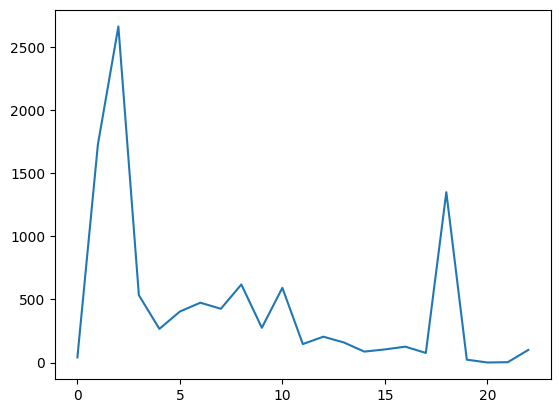

In [86]:
import matplotlib.pyplot as plt

plt.plot(train_model_res[1]['mean'].reshape(-1,1))
#plt.plot(train_model_res[1]['std'].reshape(-1,1))